In [9]:
import os

In [2]:
import pyspark

sparkConfig = pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master('local')\
    .appName('myApp')\
    .config(conf=sparkConfig)\
    .getOrCreate()

In [ ]:
myDf.write.format('com.databricks.spark.csv').save(os.path.join('data','covid_seoul_region.csv'))

In [120]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import IntegerType, DoubleType

cfile= os.path.join("data", "covid_seoul_region.csv")

# or textFile 해서 lines.map(lambda l: l.split(",")), createDataFrame
_area = spark.read.option("header", True).csv(cfile)

In [121]:
# 데이터 정제
_area = _area.drop('수집일')

In [99]:
_area.printSchema()

root
 |-- 자치구 기준일: string (nullable = true)
 |-- 종로구 전체: string (nullable = true)
 |-- 종로구 추가: string (nullable = true)
 |-- 중구 전체: string (nullable = true)
 |-- 중구 추가: string (nullable = true)
 |-- 용산구 전체: string (nullable = true)
 |-- 용산구 추가: string (nullable = true)
 |-- 성동구 전체: string (nullable = true)
 |-- 성동구 추가: string (nullable = true)
 |-- 광진구 전체: string (nullable = true)
 |-- 광진구 추가: string (nullable = true)
 |-- 동대문구 전체: string (nullable = true)
 |-- 동대문구 추가: string (nullable = true)
 |-- 중랑구 전체: string (nullable = true)
 |-- 중랑구 추가: string (nullable = true)
 |-- 성북구 전체: string (nullable = true)
 |-- 성북구 추가: string (nullable = true)
 |-- 강북구 전체: string (nullable = true)
 |-- 강북구 추가: string (nullable = true)
 |-- 도봉구 전체: string (nullable = true)
 |-- 도봉구 추가: string (nullable = true)
 |-- 노원구 전체: string (nullable = true)
 |-- 노원구 추가: string (nullable = true)
 |-- 은평구 전체: string (nullable = true)
 |-- 은평구 추가: string (nullable = true)
 |-- 서대문구 전체: string (nullable = true)
 |-- 

In [79]:
_area.take(1)

[Row(자치구 기준일='2021.06.13.00', 종로구 전체='781', 종로구 추가='1', 중구 전체='704', 중구 추가='1', 용산구 전체='1251', 용산구 추가='6', 성동구 전체='1270', 성동구 추가='4', 광진구 전체='1522', 광진구 추가='6', 동대문구 전체='1717', 동대문구 추가='14', 중랑구 전체='2063', 중랑구 추가='3', 성북구 전체='1929', 성북구 추가='4', 강북구 전체='1347', 강북구 추가='4', 도봉구 전체='1441', 도봉구 추가='4', 노원구 전체='2145', 노원구 추가='6', 은평구 전체='2005', 은평구 추가='5', 서대문구 전체='1175', 서대문구 추가='10', 마포구 전체='1475', 마포구 추가='7', 양천구 전체='1616', 양천구 추가='5', 강서구 전체='2250', 강서구 추가='1', 구로구 전체='1543', 구로구 추가='3', 금천구 전체='774', 금천구 추가='5', 영등포구 전체='1721', 영등포구 추가='6', 동작구 전체='1937', 동작구 추가='5', 관악구 전체='2128', 관악구 추가='3', 서초구 전체='1994', 서추구 추가='9', 강남구 전체='2728', 강남구 추가='27', 송파구 전체='2804', 송파구 추가='19', 강동구 전체='1868', 강동구 추가='5', 기타 전체='4290', 기타 추가='13', 수집일='11:40.0')]

# 9.1: 문제 설정
먼저 관심있는 데이터를 수집했고, 그 데이터에 대해 뭔가 궁금하게 생각하는 의문이 있을 것이다.

예를 들어 '따릉이' 데이터에 대해 (1) 대여가 증가하는 추세인지? (2) 계절별로 차이가 있는지? 의문 또는 문제를 가질 수 있겠다.

이러한 의문은 증명가능하도록 만들어져야 분석을 통해 답할 수 있다.

문제는 2개만 만들자.

# 서울 코로나 자치구별 확진자 분석 

### 1 종로구 확진자 증가 추세

### 2 지역별로 차이가 있는지?

# 9.2: 문제의 답

## 1 학교 근처 누적 확진자

### 1.1 누적 확진자 수 집계

In [163]:
# 학교 근처 지역
_areas_of_interest = ['종로구 전체', '성북구 전체', '서대문구 전체']

_filtered_columns = list(filter(lambda x: x != '자치구 기준일', _area.columns))
_filtered_columns = list(filter(lambda x: x in _areas_of_interest, _filtered_columns))

In [165]:
# lines.groupBy('자치구 기준일').pivot('month').select().show()
# lines.groupBy('자치구 기준일').pivot('자치구 기준일').sum().show()

#  맨 앞 컬럼에 헤더가 있으면 if x is not _filtered_columns
# _area.agg({"종로구 전체":"sum"}).show()
# _area.agg({"성북구 전체":"sum"}).show()
# _area.agg({"서대문구 전체":"sum"}).show()
exprs = {x: "sum" for x in _filtered_columns}

_area.agg(exprs).show()

+----------------+------------------+----------------+
|sum(성북구 전체)|sum(서대문구 전체)|sum(종로구 전체)|
+----------------+------------------+----------------+
|        282776.0|          165935.0|        119967.0|
+----------------+------------------+----------------+



### 1.2 특정 날짜 확진자 수 통계 (2021.06.13.00)

In [166]:
_area.select([c for c in _area.columns]).where(_area['자치구 기준일'].startswith('2021.06.13.00')).show()

+-------------+-----------+-----------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+-------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+-------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+-------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+---------+
|자치구 기준일|종로구 전체|종로구 추가|중구 전체|중구 추가|용산구 전체|용산구 추가|성동구 전체|성동구 추가|광진구 전체|광진구 추가|동대문구 전체|동대문구 추가|중랑구 전체|중랑구 추가|성북구 전체|성북구 추가|강북구 전체|강북구 추가|도봉구 전체|도봉구 추가|노원구 전체|노원구 추가|은평구 전체|은평구 추가|서대문구 전체|서대문구 추가|마포구 전체|마포구 추가|양천구 전체|양천구 추가|강서구 전체|강서구 추가|구로구 전체|구로구 추가|금천구 전체|금천구 추가|영등포구 전체|영등포구 추가|동작구 전체|동작구 추가|관악구 전체|관악구 추가|서초구 전체|서추구 추가|강남구 전체|강남구 추가|송파구 전체|송파구 추가|강동구 전체|

In [175]:
_area.select([c for c in _filtered_columns]).show()

+-----------+-----------+-------------+
|종로구 전체|성북구 전체|서대문구 전체|
+-----------+-----------+-------------+
|        781|       1929|         1175|
|        780|       1925|         1165|
|        778|       1920|         1157|
|        774|       1909|         1151|
|        769|       1904|         1143|
|        768|       1902|         1140|
|        767|       1894|         1140|
|        765|       1887|         1137|
|        764|       1880|         1131|
|        762|       1864|         1128|
|        761|       1855|         1122|
|        759|       1848|         1113|
|        758|       1840|         1105|
|        758|       1827|         1100|
|        758|       1823|         1097|
|        755|       1812|         1084|
|        754|       1806|         1076|
|        752|       1801|         1067|
|        748|       1794|         1056|
|        743|       1784|         1041|
+-----------+-----------+-------------+
only showing top 20 rows



In [174]:
_area.select([c for c in _filtered_columns]).describe().show()

+-------+------------------+-----------------+-----------------+
|summary|       종로구 전체|      성북구 전체|    서대문구 전체|
+-------+------------------+-----------------+-----------------+
|  count|               473|              473|              473|
|   mean|253.63002114164905|597.8350951374207|350.8139534883721|
| stddev|272.65510378910096|608.5685467871335|370.3358748874007|
|    min|               100|             1010|               10|
|    max|                98|              995|              999|
+-------+------------------+-----------------+-----------------+



### 1.3 2021년 6월 증가추세

#### 일주일 합계 

In [227]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

# from pyspark.sql.window import Window
# winAgg  = Window.partitionBy("자치구 기준일")
# _areaSumDf = _area.withColumn('sum', F.sum(F.row("자치구 기준일")).over(winAgg))
# _areaSumDf = _area.withColumn('sum', add(*[df[x] for x in df.columns]))

#b_areaSumDf = _area.withColumn('sum', add(*[df[x] for x in df.columns]))


_areaSumDf = _area.withColumn('total', sum(_area[col] for col in _filtered_columns).cast(IntegerType()))

_areaSumColumns = ['자치구 기준일', 'total'] + _filtered_columns

# 2021.06
_areaSumDf = _areaSumDf.select([c for c in _areaSumColumns]).where(_area['자치구 기준일'].startswith('2021.06'))
_areaSumDf.show()

+-------------+-----+-----------+-----------+-------------+
|자치구 기준일|total|종로구 전체|성북구 전체|서대문구 전체|
+-------------+-----+-----------+-----------+-------------+
|2021.06.13.00| 3885|        781|       1929|         1175|
|2021.06.12.00| 3870|        780|       1925|         1165|
|2021.06.11.00| 3855|        778|       1920|         1157|
|2021.06.10.00| 3834|        774|       1909|         1151|
|2021.06.09.00| 3816|        769|       1904|         1143|
|2021.06.08.00| 3810|        768|       1902|         1140|
|2021.06.07.00| 3801|        767|       1894|         1140|
|2021.06.06.00| 3789|        765|       1887|         1137|
|2021.06.05.00| 3775|        764|       1880|         1131|
|2021.06.04.00| 3754|        762|       1864|         1128|
|2021.06.03.00| 3738|        761|       1855|         1122|
|2021.06.02.00| 3720|        759|       1848|         1113|
|2021.06.01.00| 3703|        758|       1840|         1105|
+-------------+-----+-----------+-----------+-------------+



In [243]:
exprs = {x: "sum" for x in _filtered_columns}

date_list = _areaSumDf.select("자치구 기준일").rdd.map(lambda x: x[0]).collect()
totals = _areaSumDf.select("total").rdd.map(lambda x: x[0]).collect()
# for h in _areaSumDf.select("자치구 기준일").rdd.map(r => r(0)).collect():
#     print(f"h: {h.asDict}")

# _area.groupBy("자치구 기준일").agg(exprs).show()
# for h in _areaSumDf.select("자치구 기준일").collect():
#     print(f"h: {h.asDict}")

#### 증가 추이 그래프

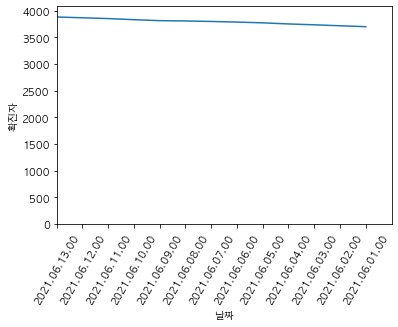

In [259]:
%matplotlib inline
import matplotlib.pyplot as plt

# 튜토리얼 https://wikidocs.net/92094

# 출처 구글: 세게은행 https://www.google.com/search?q=%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD+%EC%B4%9D+%EC%9D%B8%EA%B5%AC%EC%88%98&oq=%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD+%EC%B4%9D+%EC%9D%B8%EA%B5%AC%EC%88%98&aqs=chrome..69i57j0i3l2j0i131i433j0i3j69i65j69i61l2.2348j0j7&sourceid=chrome&ie=UTF-8
total_population_south_korea = 51710000

# 전국민 숫자를 가로선으로 긋는다.
# plt.axhline(y=total_population_south_korea, color='r', linewidth=1)

plt.plot(totals)
plt.xlabel('날짜')
plt.ylabel('확진자')
plt.ylim([0, max(totals) + 200])      # X축의 범위: [xmin, xmax]
plt.xlim([0, len(date_list)])     # Y축의 범위: [ymin, ymax]

plt.xticks([i for i, value in enumerate(date_list)], date_list, rotation=60)


plt.show()


## 2. 지역별로 차이가 있는지?

### 2.1 누적 확진자가 많은 자치구, 적은 자치구 확인

In [52]:
import pandas as pd

# 필요한 데이터 임포트
covid_seoul_region_df = pd.read_csv('data/covid_seoul_region.csv', index_col=0, engine='python', encoding='utf-8')

# 필터링
mask = covid_seoul_region_df.index != '20'
covid_seoul_region_df = covid_seoul_region_df.loc[mask, :]

# 불필요한 '수집일' 열 제거
covid_seoul_region_df = covid_seoul_region_df.drop('수집일', axis=1)
 
covid_seoul_region_total_df = covid_seoul_region_df.T[covid_seoul_region_df.T.index.str.contains("전체")]
covid_seoul_region_today_df = covid_seoul_region_df.T[covid_seoul_region_df.T.index.str.contains("추가")]

In [54]:
# Prepare Data
labels = covid_seoul_region_total_df.index.values.tolist()
sizes = covid_seoul_region_total_df.iloc[:,0]
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

Text(0.5, 1.0, '코로나 발생자 수 지역 별 분석')

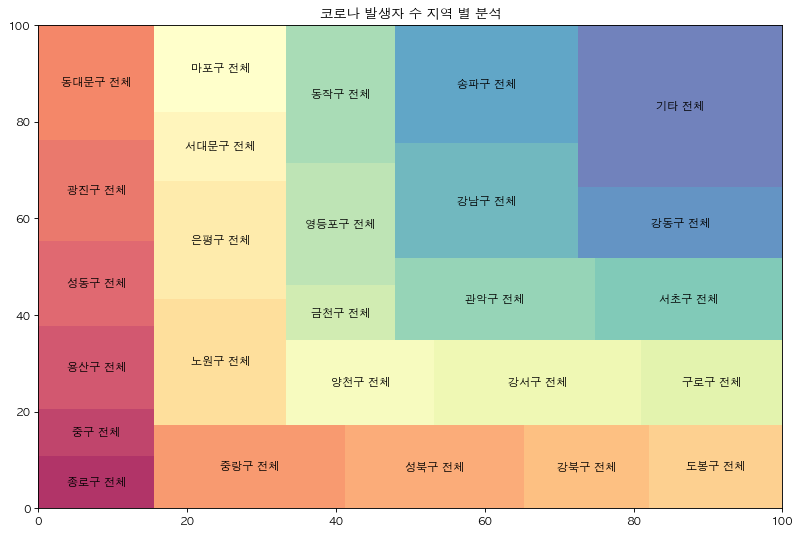

In [57]:
import squarify
import matplotlib.pyplot as plt
# plot 스타일을 미리 정의해놓은 패키지
import seaborn as sns

# 한글 폰트
plt.rcParams['font.family'] = 'AppleGothic'

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('코로나 발생자 수 지역 별 분석')